In [28]:
import urllib.request
import pickle, csv, json, os, re
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from statistics import mode, mean, median
from tqdm import tqdm
import requests

plt.rcParams["figure.figsize"] = (20,10)

# Data

We load in our stored local animes and mangas

In [29]:
import os
anime_dir_path = "data/animes/"

anime_dir = os.listdir(anime_dir_path)
all_animes = []
for file in anime_dir:
    with open(os.path.join(anime_dir_path, file),'r') as f:
        j = json.loads(f.read())
    all_animes.append(j)

In [30]:
all_anime_tv = [x for x in all_animes if x['type'] == 'TV']
print(len(all_anime_tv))
all_anime_tv = [x for x in all_anime_tv if x['score']]
print(len(all_anime_tv))
all_anime_tv = [x for x in all_anime_tv if x['synopsis']]
print(len(all_anime_tv))

8319
4320
4301


## Data Structure

In [31]:
import pandas as pd

df = pd.DataFrame(all_anime_tv)

# Uncertain if we should keep licensors
df = df.drop(["trailer","images","approved","url","titles","title_japanese",
"title_synonyms","type", "status", "aired", "broadcast", "producers", "background", 
"licensors","title_english", "explicit_genres"], axis='columns') 

# Function to turn json text to list format
def extractFromJsonToList(category):
    for mal_id in range(0,len(df.index)):
        items = []
        for item in range(0,len(df[category][mal_id])):
           items.append(df[category][mal_id][item]['name'])
        df[category][mal_id] = items

Change json text to list of strings

In [32]:
extractFromJsonToList('genres')
extractFromJsonToList('themes')
extractFromJsonToList('demographics')
extractFromJsonToList('studios')
print(print(df.columns))

<ipython-input-31-791689ec8400>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[category][mal_id] = items


Index(['mal_id', 'title', 'source', 'episodes', 'airing', 'duration', 'rating',
       'score', 'scored_by', 'rank', 'popularity', 'members', 'favorites',
       'synopsis', 'season', 'year', 'studios', 'genres', 'themes',
       'demographics'],
      dtype='object')
None


Indexing by myanimelist index

In [33]:
df = df.set_index('mal_id')

Show dataframe

In [34]:
df

,title,source,episodes,airing,duration,rating,score,scored_by,rank,popularity,members,favorites,synopsis,season,year,studios,genres,themes,demographics
mal_id,,,,,,,,,,,,,,,,,,,
5235,Live On Cardliver Kakeru,Manga,51.0,False,23 min per ep,PG - Children,6.38,256,7119,11675,1134,5,"Kakeru is a big fan of the Live On card game, ...",fall,2008.0,[TMS Entertainment],[Fantasy],[Strategy Game],[]
1735,Naruto: Shippuuden,Manga,500.0,False,23 min per ep,PG-13 - Teens 13 or older,8.25,1487306,283,16,2212915,102011,It has been two and a half years since Naruto ...,winter,2007.0,[Pierrot],"[Action, Adventure, Fantasy]",[Martial Arts],[Shounen]
2228,Honoo no Toukyuuji: Dodge Danpei,Manga,47.0,False,25 min per ep,PG - Children,7.30,2620,2496,7707,4893,25,Danpei Ichihgeki is the son of Daijurou Ichige...,fall,1991.0,[Animation 21],"[Comedy, Sports]","[School, Team Sports]",[Kids]
3136,Ochamegami Monogatari: Korokoro Pollon,Manga,46.0,False,22 min per ep,G - All Ages,6.93,1375,4263,9171,2887,7,Anime about the funny lives of the Greek gods ...,spring,1982.0,[Kokusai Eigasha],[Comedy],[Parody],[]
1721,Hitohira,Manga,12.0,False,23 min per ep,PG-13 - Teens 13 or older,6.75,7396,5097,4422,19448,30,A transfer student Asai Mugi is a painfully sh...,spring,2007.0,[XEBEC M2],"[Drama, Romance, Slice of Life]","[Performing Arts, School]",[Seinen]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,Alps no Shoujo Heidi,Book,52.0,False,25 min per ep,PG - Children,7.34,17656,2316,3411,33674,287,"After becoming an orphan, Heidi is forced to l...",winter,1974.0,[Nippon Animation],[Drama],[Historical],[]
12175,Koi to Senkyo to Chocolate,Visual novel,12.0,False,25 min per ep,PG-13 - Teens 13 or older,7.01,97362,3926,897,231353,446,Yuuki Oojima is a member of his high school's ...,summer,2012.0,[AIC Build],"[Drama, Romance]",[School],[]
2543,Robin Hood no Daibouken,Unknown,52.0,False,25 min per ep,G - All Ages,7.09,3803,3569,6259,8149,29,A variant of Robin Hood in which all the princ...,summer,1990.0,[Tatsunoko Production],"[Adventure, Romance]",[Historical],[]


Show data from a particular anime based on myanimelist index

In [35]:
df.loc[21]

title                                                   One Piece
source                                                      Manga
episodes                                                      NaN
airing                                                       True
duration                                                   24 min
rating                                  PG-13 - Teens 13 or older
score                                                        8.67
scored_by                                                 1140526
rank                                                           60
popularity                                                     23
members                                                   1997951
favorites                                                  181458
synopsis        Gol D. Roger was known as the "Pirate King," t...
season                                                       fall
year                                                         1999
studios   

Make graph to get degrees for recommendations for our data structure

In [36]:
all_anime_tv_id = [anime['mal_id'] for anime in all_anime_tv]
anime_graph = nx.Graph()
anime_graph.add_nodes_from(all_anime_tv_id)

fh = open("data/edgeanimelist.txt", 'r') 
anime_edge_graph = nx.read_weighted_edgelist(fh, nodetype = int)

anime_graph.add_edges_from(anime_edge_graph.edges(data = True))
print(len(anime_graph))

4301


Add amount of recommendations into the dataframe

In [37]:
recommendations = [degree for _, degree in anime_graph.degree]
df['recommendations'] = recommendations

## Threshold for succesful and non-succesful anime

Correlation matrix to find the data that matters

                    score   members  favorites  recommendations  episodes  \
score            1.000000  0.464375   0.342202         0.460049 -0.032891   
members          0.464375  1.000000   0.776820         0.699449 -0.029849   
favorites        0.342202  0.776820   1.000000         0.596950  0.024883   
recommendations  0.460049  0.699449   0.596950         1.000000 -0.026743   
episodes        -0.032891 -0.029849   0.024883        -0.026743  1.000000   
rank            -0.976225 -0.409823  -0.263029        -0.442601  0.041231   
scored_by        0.420340  0.989032   0.782911         0.648800 -0.019482   
popularity      -0.577295 -0.479815  -0.236168        -0.506101  0.166285   

                     rank  scored_by  popularity  
score           -0.976225   0.420340   -0.577295  
members         -0.409823   0.989032   -0.479815  
favorites       -0.263029   0.782911   -0.236168  
recommendations -0.442601   0.648800   -0.506101  
episodes         0.041231  -0.019482    0.166285  


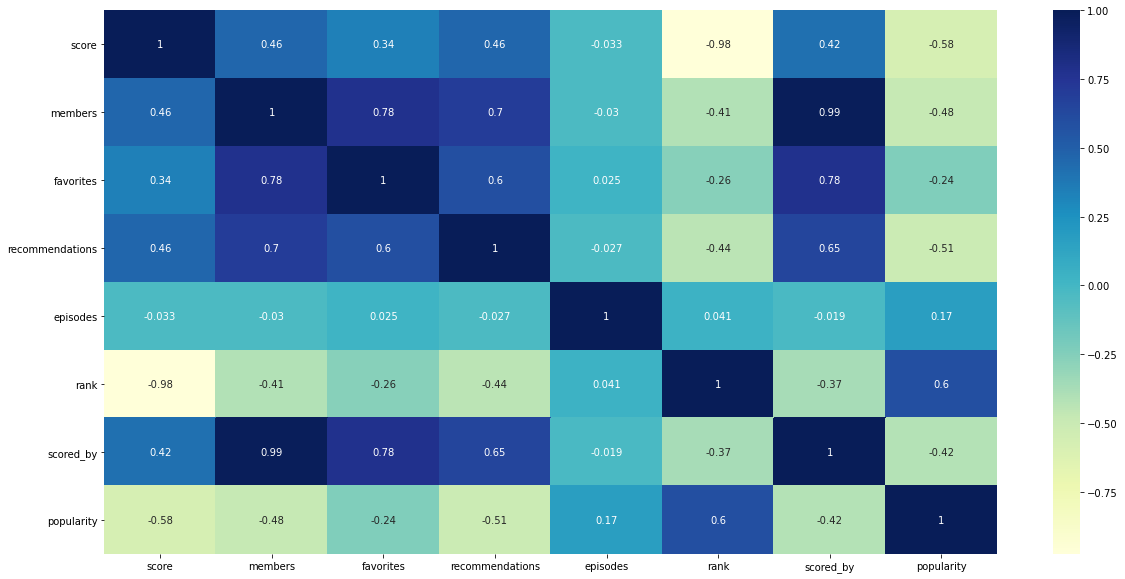

In [38]:
import seaborn as sb


# prints data that will be plotted for the correlation matrix
print(df[['score','members','favorites','recommendations', 'episodes','rank','scored_by','popularity']].corr())
  
# plot correlation heatmap
dataplot = sb.heatmap(df[['score','members','favorites','recommendations', 'episodes','rank','scored_by','popularity']].corr(), cmap="YlGnBu", annot=True)
plt.show()

Since our links are recommendations and the one that is most correlated to this was members. Therefore we chose this for our thresholding for succesful and non-succesful anime

In [39]:
# Sort by members in descending order
df = df.sort_values(by=['members'], ascending = False)
df[['members','title']]

,members,title
mal_id,,
16498,3557008,Shingeki no Kyojin
1535,3536876,Death Note
5114,3013611,Fullmetal Alchemist: Brotherhood
30276,2907138,One Punch Man
11757,2834266,Sword Art Online
...,...,...
27467,321,Yoligongju Loopy
27453,308,Pororo-wa Noraehaeyo
38379,291,Lei Su Deng Shandian Chong Xian 3


In [40]:
# Our thresholds
per10 = round(len(df)*0.1)
per90 = round(len(df)*0.9)

Now we want to check the nearby anime to see if there are outliers in terms of distnace between two anime. This is to check whether our thresholding is good enough

In [41]:
df[['members','title']].iloc[per10-20:per10+20]

,members,title
mal_id,,
31636,422102,Dagashi Kashi
37171,421415,Asobi Asobase
27989,420355,Hibike! Euphonium
9656,420248,Kimi ni Todoke 2nd Season
237,417563,Koukyoushihen Eureka Seven
24765,417371,Gakkougurashi!
25835,417142,Shirobako
13659,414947,Ore no Imouto ga Konnani Kawaii Wake ga Nai.
32899,413838,Watashi ga Motete Dousunda


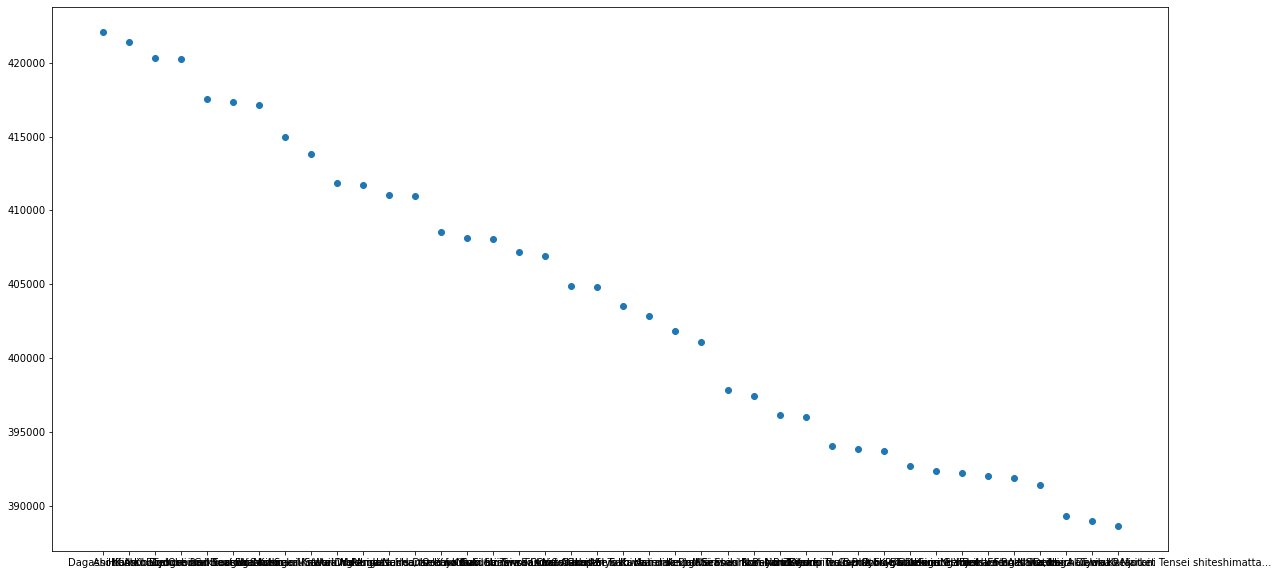

In [42]:
plt.scatter(df['title'].iloc[per10-20:per10+20], df['members'].iloc[per10-20:per10+20])

In [43]:
df[['members','title']].iloc[per90-20:per90+20]

,members,title
mal_id,,
5395,1340,Nekketsu Saikyou Go-Saurer
10250,1335,Ultra B
5908,1334,Chinpui
29722,1327,"Eikoku Ikka, Nihon wo Taberu"
17969,1326,Tanken Driland: 1000-nen no Mahou
3434,1317,Hey! Bumboo
749,1312,Nanami-chan
5143,1310,Tokusou Kihei Dorvack
32582,1308,Duel Masters VSRF


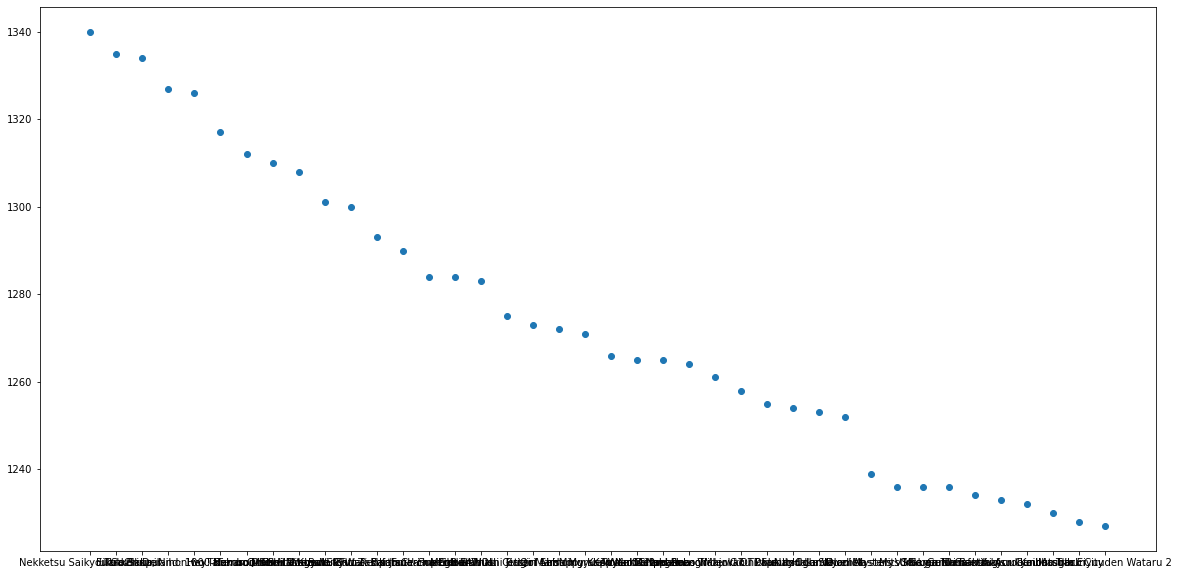

In [44]:
plt.scatter(df['title'].iloc[per90-20:per90+20], df['members'].iloc[per90-20:per90+20])

Now to check how much the largest gap is

In [45]:
def maxGap(ID):
    max = 0
    maxID = 0
    for i in range(ID, ID+40):
        diff = df['members'].iloc[i]-df['members'].iloc[i+1]
        if (diff > max):
            maxID = i
            max = diff
    print(max)
    print(f"The gap is {max/df['members'].iloc[i]*100}% with the total amount of members of mal_ID {maxID}: {df['members'].iloc[i]}")
    return maxID

In [46]:
maxGap(per10-20)

3273
The gap is 0.8422304052124104% with the total amount of members of mal_ID 433: 388611


433

In [47]:
maxGap(per90-20)

13
The gap is 1.0594947025264874% with the total amount of members of mal_ID 3880: 1227


3880

We can conclude that the gap between an anime and its neighbors are not significant enough for us to change the thresholds. We will keep it as it is

In [48]:
succes_anime = df.iloc[:per10]
succes_anime

,title,source,episodes,airing,duration,rating,score,scored_by,rank,popularity,members,favorites,synopsis,season,year,studios,genres,themes,demographics,recommendations
mal_id,,,,,,,,,,,,,,,,,,,,
16498,Shingeki no Kyojin,Manga,25.0,False,24 min per ep,R - 17+ (violence & profanity),8.53,2541927,106,1,3557008,156956,"Centuries ago, mankind was slaughtered to near...",spring,2013.0,[Wit Studio],"[Action, Award Winning, Drama, Suspense]","[Gore, Military, Survival]",[Shounen],166
1535,Death Note,Manga,37.0,False,23 min per ep,R - 17+ (violence & profanity),8.62,2507504,76,2,3536876,161133,"Brutal murders, petty thefts, and senseless vi...",fall,2006.0,[Madhouse],"[Supernatural, Suspense]",[Psychological],[Shounen],191
5114,Fullmetal Alchemist: Brotherhood,Manga,64.0,False,24 min per ep,R - 17+ (violence & profanity),9.12,1923605,1,3,3013611,209595,After a horrific alchemy experiment goes wrong...,spring,2009.0,[Bones],"[Action, Adventure, Drama, Fantasy]",[Military],[Shounen],151
30276,One Punch Man,Web manga,12.0,False,24 min per ep,R - 17+ (violence & profanity),8.51,2037234,118,4,2907138,60136,The seemingly unimpressive Saitama has a rathe...,fall,2015.0,[Madhouse],"[Action, Comedy]","[Adult Cast, Parody, Super Power]",[Seinen],114
11757,Sword Art Online,Light novel,25.0,False,23 min per ep,PG-13 - Teens 13 or older,7.20,2003597,3038,5,2834266,65334,Ever since the release of the innovative Nerve...,summer,2012.0,[A-1 Pictures],"[Action, Adventure, Fantasy, Romance]","[Love Polygon, Video Game]",[],167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7785,Yojouhan Shinwa Taikei,Novel,11.0,False,23 min per ep,R - 17+ (violence & profanity),8.57,132733,91,472,408075,17056,One autumn evening at a mysterious ramen stand...,spring,2010.0,[Madhouse],"[Award Winning, Comedy, Mystery, Romance]","[Psychological, Time Travel]",[],68
38483,Ore wo Suki nano wa Omae dake ka yo,Light novel,12.0,False,23 min per ep,PG-13 - Teens 13 or older,7.32,221089,2405,473,407180,2091,"Amatsuyu ""Jouro"" Kisaragi is a completely aver...",fall,2019.0,[Connect],"[Comedy, Romance]","[Harem, School]",[],31
41226,Uzaki-chan wa Asobitai!,Manga,12.0,False,23 min per ep,PG-13 - Teens 13 or older,7.01,222659,3948,474,406917,1536,"At the start of her freshman year in college, ...",summer,2020.0,[ENGI],[Comedy],"[Adult Cast, Romantic Subtext]",[],25


In [49]:
failure_anime = df.iloc[per90:]
failure_anime

,title,source,episodes,airing,duration,rating,score,scored_by,rank,popularity,members,favorites,synopsis,season,year,studios,genres,themes,demographics,recommendations
mal_id,,,,,,,,,,,,,,,,,,,,
15905,Qin Shi Mingyue: Wanli Changcheng,Novel,37.0,False,22 min per ep,PG-13 - Teens 13 or older,7.03,328,3849,11400,1266,10,Continues the story of Tianming from where the...,fall,2012.0,[Sparkly Key Animation Studio],"[Action, Fantasy]","[Historical, Martial Arts]",[],0
307,Kerokko Demetan,Unknown,39.0,False,24 min per ep,PG - Children,5.93,511,9511,11400,1265,3,Demetan comes from such a poor family that he ...,winter,1973.0,[Tatsunoko Production],"[Comedy, Fantasy]",[],[Kids],0
31673,Larva 2nd Season,Original,52.0,False,4 min per ep,G - All Ages,6.18,718,8183,11385,1265,2,Second season of Larva.,winter,2013.0,[],[Comedy],[],[],0
4536,Muteki Robo Trider G7,Original,50.0,False,24 min per ep,G - All Ages,6.30,368,7556,11402,1264,1,Takeo Watta inherits a company upon his father...,winter,1980.0,[Sunrise],"[Comedy, Sci-Fi]","[Mecha, Space]",[],0
39581,TV Yarou Nanaana: Wakuwaku Doukutsu Land,Original,24.0,False,3 min per ep,PG-13 - Teens 13 or older,6.07,490,8797,11411,1261,3,"After the TV station gets acquired by ""Nanazon...",spring,2019.0,[Studio Crocodile],"[Adventure, Comedy]",[Workplace],[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27467,Yoligongju Loopy,Unknown,6.0,False,5 min per ep,G - All Ages,5.65,117,10727,15891,321,0,"A spin-off Pororo series focusing around food,...",None,NaN,[],[Gourmet],[],[Kids],0
27453,Pororo-wa Noraehaeyo,Unknown,14.0,False,3 min per ep,G - All Ages,5.64,122,10741,16098,308,0,Sing-A-Long with Pororo and his friends. The s...,None,NaN,[],[],"[Music, Performing Arts]",[Kids],0
38379,Lei Su Deng Shandian Chong Xian 3,Original,40.0,False,24 min per ep,G - All Ages,6.09,124,8675,16336,291,0,The third season of Lei Su Deng Shandian Chong...,None,NaN,[],[],[Racing],[Kids],0


## Basic stats & Graphs

#### Basic stats

GCC for all anime

In [50]:
# Since we have a lot of nodes without recommendations, it is best to find the GCC of our graph
GCC = max(nx.connected_components(anime_graph), key=len)
anime_GCC = anime_graph.subgraph(GCC).copy()
print(len(anime_GCC))

3487


In [51]:
anime_from_GCC = df.loc[list(anime_GCC.nodes)]
anime_from_GCC

,title,source,episodes,airing,duration,rating,score,scored_by,rank,popularity,members,favorites,synopsis,season,year,studios,genres,themes,demographics,recommendations
mal_id,,,,,,,,,,,,,,,,,,,,
5235,Live On Cardliver Kakeru,Manga,51.0,False,23 min per ep,PG - Children,6.38,256,7119,11675,1134,5,"Kakeru is a big fan of the Live On card game, ...",fall,2008.0,[TMS Entertainment],[Fantasy],[Strategy Game],[],3
1735,Naruto: Shippuuden,Manga,500.0,False,23 min per ep,PG-13 - Teens 13 or older,8.25,1487306,283,16,2212915,102011,It has been two and a half years since Naruto ...,winter,2007.0,[Pierrot],"[Action, Adventure, Fantasy]",[Martial Arts],[Shounen],90
2228,Honoo no Toukyuuji: Dodge Danpei,Manga,47.0,False,25 min per ep,PG - Children,7.30,2620,2496,7707,4893,25,Danpei Ichihgeki is the son of Daijurou Ichige...,fall,1991.0,[Animation 21],"[Comedy, Sports]","[School, Team Sports]",[Kids],1
3136,Ochamegami Monogatari: Korokoro Pollon,Manga,46.0,False,22 min per ep,G - All Ages,6.93,1375,4263,9171,2887,7,Anime about the funny lives of the Greek gods ...,spring,1982.0,[Kokusai Eigasha],[Comedy],[Parody],[],39
1721,Hitohira,Manga,12.0,False,23 min per ep,PG-13 - Teens 13 or older,6.75,7396,5097,4422,19448,30,A transfer student Asai Mugi is a painfully sh...,spring,2007.0,[XEBEC M2],"[Drama, Romance, Slice of Life]","[Performing Arts, School]",[Seinen],15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50346,Yofukashi no Uta,Manga,13.0,False,22 min per ep,PG-13 - Teens 13 or older,8.10,140663,455,502,388427,4993,Kou Yamori is an average middle school student...,summer,2022.0,[LIDENFILMS],"[Romance, Supernatural]",[Vampire],[Shounen],11
2225,Alps no Shoujo Heidi,Book,52.0,False,25 min per ep,PG - Children,7.34,17656,2316,3411,33674,287,"After becoming an orphan, Heidi is forced to l...",winter,1974.0,[Nippon Animation],[Drama],[Historical],[],12
12175,Koi to Senkyo to Chocolate,Visual novel,12.0,False,25 min per ep,PG-13 - Teens 13 or older,7.01,97362,3926,897,231353,446,Yuuki Oojima is a member of his high school's ...,summer,2012.0,[AIC Build],"[Drama, Romance]",[School],[],29


In [52]:
succes_anime_from_GCC = set(succes_anime.index) & set(anime_from_GCC.index)
len(succes_anime_from_GCC)

425

The above code explains that only 5 anime are not part of the GCC out of 430 successful anime, we will now figure out what 5 anime is not part of it

In [53]:
removed_anime = list(set(succes_anime.index)-succes_anime_from_GCC)
removed_anime

[40356, 39940, 49926, 31181, 39701]

In [54]:
len(removed_anime)/len(succes_anime)*100

1.1627906976744187

In [55]:
df.loc[removed_anime]

,title,source,episodes,airing,duration,rating,score,scored_by,rank,popularity,members,favorites,synopsis,season,year,studios,genres,themes,demographics,recommendations
mal_id,,,,,,,,,,,,,,,,,,,,
40356,Tate no Yuusha no Nariagari Season 2,Light novel,13.0,False,23 min per ep,PG-13 - Teens 13 or older,6.56,174289,6111,286,620894,12341,"With another Wave happening in a week, Naofumi...",spring,2022.0,"[Kinema Citrus, DR Movie]","[Action, Adventure, Drama, Fantasy]",[Isekai],[],0
39940,Shokugeki no Souma: Shin no Sara,Manga,12.0,False,24 min per ep,PG-13 - Teens 13 or older,7.75,320020,1001,341,551175,1292,"At Tootsuki Culinary Academy, a heated eight-o...",fall,2019.0,[J.C.Staff],"[Gourmet, Ecchi]",[School],[Shounen],0
49926,Kimetsu no Yaiba: Mugen Ressha-hen,Manga,7.0,False,24 min per ep,R - 17+ (violence & profanity),8.38,297005,182,375,507011,3413,A mysterious string of disappearances on a cer...,fall,2021.0,[ufotable],"[Action, Fantasy]",[Historical],[Shounen],0
31181,Owarimonogatari,Light novel,12.0,False,26 min per ep,R - 17+ (violence & profanity),8.45,218887,144,431,446378,2752,A peculiar transfer student named Ougi Oshino ...,fall,2015.0,[Shaft],"[Comedy, Mystery, Supernatural]",[Vampire],[],0
39701,Nanatsu no Taizai: Kamigami no Gekirin,Manga,24.0,False,24 min per ep,PG-13 - Teens 13 or older,6.45,374054,6768,265,654016,1345,After saving the Kingdom of Liones from the 10...,fall,2019.0,[Studio Deen],"[Action, Adventure, Fantasy]",[],[Shounen],0


The popular anime above that are removed anime from the GCC happens to be all sequels, which makes sense, since you would usually not recommend a sequel of an anime despite the sequel containing a lot of members. Although some sequels do have reommendations, for example Shokugeki no Souma: Shin no Sara, which is basically food wars season 4 do not have recommendations. The anime food wars have 5 seasons, which means every season beside season 4 got a recommendation. Since they all have 0 recommendations, therefore 0 edges, it will not make sense to add them for community detection as they are not linked to other nodes, they will therefore be noisy data for the community detection.

In [56]:
def get_degree_properties(graph):
    out_degrees = []
    prop = {}
    prop['out'] = {}
    prop['in'] = {}
    
    for _ , d in graph.degree():
        out_degrees.append(d)
        
    prop['outdegrees'] = out_degrees

    
    prop['out']['max'] = max(out_degrees)

    
    prop['out']['min'] = min(out_degrees)

    
    prop['out']['avg'] = mean(out_degrees)

    
    prop['out']['median'] = median(out_degrees)

    
    prop['out']['mode'] = mode(out_degrees)

    
    return prop

properties = get_degree_properties(anime_GCC)
print("Out:",properties['out'])
print("In:",properties['in'])

Out: {'max': 245, 'min': 1, 'avg': 20.13478634929739, 'median': 11, 'mode': 1}
In: {}


In [57]:
# Overall
sorted_popular_anime = sorted(anime_GCC.degree, key=lambda x: x[1], reverse=True)[0:5]
sorted_popular_anime = [(int(x),y) for (x,y) in sorted_popular_anime]

sorted_popular_anime = [(anime['titles'][0]['title'], count) for (id, count) in sorted_popular_anime for anime in all_anime_tv if id == anime['mal_id']]
print(sorted_popular_anime)

[('Mahou Shoujo Madoka★Magica', 245), ('Code Geass: Hangyaku no Lelouch', 236), ('Neon Genesis Evangelion', 232), ('Gintama', 207), ('Tengen Toppa Gurren Lagann', 193)]


In [58]:
C_anime_full = [(k, v) for k, v in nx.degree_centrality(anime_GCC).items()]

C_anime_v = [v for k, v in nx.degree_centrality(anime_GCC).items()]
print("avg anime degree centrality:",mean(C_anime_v))

avg anime degree centrality: 0.005775899698593628


In [59]:
import random
def shuffle_network(graph):
    # create a random mapping old label -> new label
    node_mapping = dict(zip(graph.nodes(), sorted(graph.nodes(), key=lambda k: random.random())))
    # build a new graph
    R = nx.relabel_nodes(graph, node_mapping)
    
    return R

In [60]:
R = shuffle_network(anime_GCC)

print(R)

In [61]:
R_anime_C = []

for i in range(1000):
    R = shuffle_network(anime_GCC)
    R_anime_C.append(R)
    C_anime_v = [v for k, v in nx.degree_centrality(R).items()]
    R_anime_C.append(mean(C_anime_v))

In [62]:
len(R_anime_C[0].nodes)

3487

In [63]:
# Overall
sorted_popular_anime = sorted(R_anime_C[0].degree, key=lambda x: x[1], reverse=True)[0:5]
sorted_popular_anime = [(int(x),y) for (x,y) in sorted_popular_anime]

sorted_popular_anime = [(anime['titles'][0]['title'], count) for (id, count) in sorted_popular_anime for anime in all_anime_tv if id == anime['mal_id']]
print(sorted_popular_anime)

[('Blassreiter', 245), ('Mahou no Idol Pastel Yumi', 236), ('Haikyuu!! To the Top Part 2', 232), ('No Game No Life', 207), ('Nami yo Kiitekure', 193)]


In [64]:
# Overall
sorted_popular_anime = sorted(R_anime_C[2].degree, key=lambda x: x[1], reverse=True)[0:5]
sorted_popular_anime = [(int(x),y) for (x,y) in sorted_popular_anime]

sorted_popular_anime = [(anime['titles'][0]['title'], count) for (id, count) in sorted_popular_anime for anime in all_anime_tv if id == anime['mal_id']]
print(sorted_popular_anime)

[('Mushikaburi-hime', 245), ('Garo: Honoo no Kokuin', 236), ('One Punch Man 2nd Season', 232), ('Gunparade Orchestra', 207), ('Majo no Tabitabi', 193)]


# Community Detection

In [65]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import re
import nltk
import matplotlib.pyplot as plt

In [66]:
# Lemmatization of lists
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def lemmatizeList(list):
    lemma_list = []
    for word, tag in pos_tag(list):
        lemma = WordNetLemmatizer().lemmatize(word, tag_map[tag[0]])
        lemma_list.append(lemma)
    return lemma_list

Function to get all mal_ids of each community

In [67]:
def createAnimeCommunities(partition, commuity_list):
    communites = []
    for i in commuity_list:
        anime_mal_ids = [key for key, value in partition.items() if value == i]
        communites.append(anime_mal_ids)
    return communites

Function to process text from each community and their texts

In [68]:
def text_processing(partition, community_list):

    corpus = []
    for i in community_list:
        anime_community_ids = [key for key, value in partition.items() if value == i]
        text = ""
        # Loop through all the anime and find the one that are within the community, add text
        for anime in all_anime_tv:        
            if (anime['mal_id'] in anime_community_ids):
                end = -1
                try:
                    end = re.search("(\[Written by.*]|\(Source:.*\))",anime['synopsis']).span()[0] 
                except AttributeError:
                    pass
                
                text += anime['synopsis'][:end]
                
                # Only for anime id 5725 makes the change of word from cards to card, which does not influence
                # The end result, therefore end will be -1, in case the synopsis doesn't state the source
                if(anime['synopsis'][end].isalpha()): 
                    print(anime['mal_id'])
        
                
        tokens = word_tokenize(re.sub("[^0-9a-zA-Z\s_-]+","",text))

        # Process each document of the text of a community through lemmatization, remove stop words and only take words/numbers.
        stop_words = stopwords.words('english')

        processed_text_1 = lemmatizeList([w.lower() for w in tokens])
        processed_text_2 = [w for w in processed_text_1 if not w in stop_words]
        corpus.append(processed_text_2)

    return corpus

### For all anime

To ensure we have the same results each time, random seed is used

In [80]:
import random
import sys
import networkx.algorithms.community as nx_com
import community

# create a seed
seed_value = random.randrange(sys.maxsize)
# Output 1
seed_value = 0
# Now, Seed the random number generator
# random.seed(seed_value)

In [81]:
# Find the best partition for each universe - using the louvain algorithm
best_modularity = 0
for i in range(0,100):
    anime_partition = community.best_partition(anime_GCC, weight = 'weight', random_state = i)
    modularity = community.modularity(anime_partition,anime_GCC, weight = 'weight')
    if (modularity > best_modularity):
        best_modularity = modularity
        seed_value = i

print(best_modularity)

0.5274098056804057


In [82]:
# Current seed
print(seed_value)
anime_partition = community.best_partition(anime_GCC, weight = 'weight', random_state = seed_value)

76


In [83]:
anime_partition_values = [anime_partition.get(node) for node in anime_GCC.nodes()]

In [84]:
anime_communities = {}

for key in anime_partition_values:
    if key in anime_communities:
        anime_communities[key] += 1
    else:
        anime_communities[key] = 1

print("The anime network partition consists of", len(anime_communities), "communities and the sizes of the communities are", list(anime_communities.values()))

The anime network partition consists of 13 communities and the sizes of the communities are [137, 211, 258, 532, 633, 274, 276, 260, 79, 97, 320, 172, 238]


#### Visualize the communities by coloring the graph's nodes according to community affiliation

In [85]:
import matplotlib.colors as colors
import fa2

def fa_community_plot(graph, partition):  
    forceatlas2 = fa2.ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,
                            linLogMode=False,
                            adjustSizes=False,
                            edgeWeightInfluence=0.5,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=1.0,
                            strongGravityMode=True,
                            gravity=1.0,

                            # Log
                            verbose=False)

    positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=1000)
    nx.draw_networkx_edges(graph, positions, edge_color="yellow", alpha=0.2)
    #Count is used to give each community their own color
    count = 0
    #Go through each community and draw all the nodes in the same color
    for com in set(partition.values()) :
        count = count + 1
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
        color = list(colors.cnames.keys())[count]
        nx.draw_networkx_nodes(graph, positions, list_nodes, node_size = 100, node_color = str(color), alpha=1)
    plt.axis('off')
    plt.show()

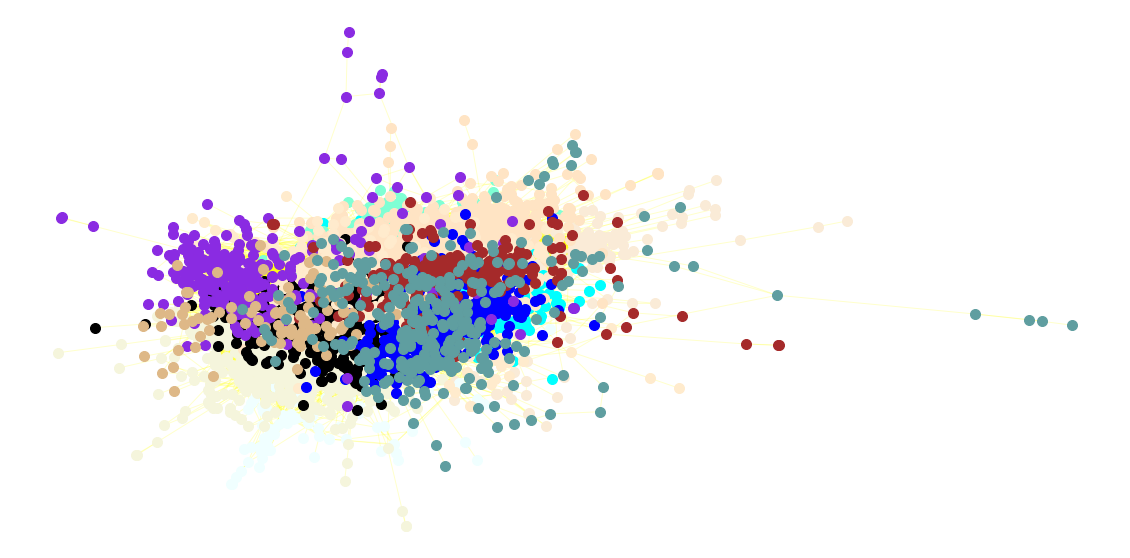

In [86]:
fa_community_plot(anime_GCC, anime_partition)

In [87]:
anime_freq = nltk.FreqDist(anime_partition_values)
anime_freq

FreqDist({4: 633, 5: 532, 12: 320, 7: 276, 6: 274, 8: 260, 9: 258, 2: 238, 10: 211, 1: 172, ...})

In [88]:
# Based on what we know of the sizes of each community, it is probably only interesting to look at the 12 biggest communities.
community_list = list(anime_freq)
anime_corpus = text_processing(anime_partition, community_list)

5725


In [89]:
# A list of all the tf list from each community
community_list_freq= []

for i, community_text in zip(list(anime_freq), anime_corpus):
    
    # To have the term frequency in count
    term_freqdist = nltk.FreqDist(community_text)

    # To have the term frequency in count / N format, which is the tf-format of the example from the wikipage of TF-IDF
    total = term_freqdist.N()
    for word in term_freqdist:
        term_freqdist[word] /= float(total)
    
    # Add every term frequency distribution for a community in our list
    community_list_freq.append(term_freqdist)

    # Printing out the top 5 terms of each community (percentage)
    print("Community " + str(i) + " has " + str(anime_freq[i]) + " anime and has these top 5 terms according to TF:")
    print(term_freqdist.most_common(5))

Community 4 has 633 anime and has these top 5 terms according to TF:
[('school', 0.011595677050222505), ('girl', 0.008645899554990464), ('life', 0.007450731087094723), ('new', 0.005670692943420216), ('one', 0.005594405594405594)]
Community 5 has 532 anime and has these top 5 terms according to TF:
[('world', 0.007083163473298002), ('one', 0.005962087240114146), ('however', 0.005376070118222585), ('life', 0.0052741540970240525), ('earth', 0.005121280065226254)]
Community 12 has 320 anime and has these top 5 terms according to TF:
[('girl', 0.011890606420927468), ('world', 0.00836915759626818), ('school', 0.006768499039604866), ('one', 0.0062654349217963964), ('become', 0.005305039787798408)]
Community 7 has 276 anime and has these top 5 terms according to TF:
[('one', 0.00727906499897478), ('world', 0.0065101496821816695), ('life', 0.005484929259790855), ('find', 0.005279885175312692), ('young', 0.004767274964117285)]
Community 6 has 274 anime and has these top 5 terms according to TF:


In [90]:
# In this code section, we want to calculate the IDF of every word from the whole anime_corpus
idf_list = []
# Extract all words from the whole anime_corpus
anime_words = [item for document in anime_corpus for item in document]
anime_words = set(anime_words)

# Check amount of occurence of a word
for word in anime_words:
    occurences = 0

    # Check if the word occurs on each community text. Max occurence is the total amount of text documents of the corpus
    for community_text in anime_corpus:
        if word in community_text:
            occurences += 1
    
    # Calculate the inverse document frequency
    idf = np.log(len(anime_corpus)/occurences)
    idf_list.append((word,idf))

# Convert the list of tuples to a dictionary, which we will use later
idf_dict = dict(idf_list)

KeyboardInterrupt: 

In [ ]:
idf_list

[('otaku-hating', 2.5649493574615367),
 ('accuracy', 2.5649493574615367),
 ('value', 0.6190392084062235),
 ('kakumeiki', 2.5649493574615367),
 ('threatening', 1.8718021769015913),
 ('valt', 1.8718021769015913),
 ('destine', 0.4855078157817008),
 ('dennis', 2.5649493574615367),
 ('futo', 2.5649493574615367),
 ('valiante', 2.5649493574615367),
 ('superheroes', 2.5649493574615367),
 ('haruta', 2.5649493574615367),
 ('yuika', 2.5649493574615367),
 ('pre-teen', 2.5649493574615367),
 ('yokomi', 2.5649493574615367),
 ('kotori', 1.1786549963416462),
 ('mountaineering', 2.5649493574615367),
 ('unimpressed', 2.5649493574615367),
 ('converge', 1.8718021769015913),
 ('kakaru', 2.5649493574615367),
 ('brantini', 2.5649493574615367),
 ('fairilu', 2.5649493574615367),
 ('nonentity', 2.5649493574615367),
 ('tablekio', 2.5649493574615367),
 ('falklands', 2.5649493574615367),
 ('ai', 0.26236426446749106),
 ('kurumada', 2.5649493574615367),
 ('vanilla', 1.8718021769015913),
 ('stargazer', 2.5649493574615

In [ ]:
# A list of all the tf-idf list from each community
community_list_tf_idf = []

for term_freqdist in community_list_freq:
    community_tf_idf = nltk.FreqDist(term_freqdist) # Copies values and ensures that we don't overwrite tf distribution

    for word in community_tf_idf:

        # Get the idf of the word from the idf dictionary we made previously
        idf = idf_dict[word]

        # tf-idf is calculated by the tf of a word within the document and the idf of the word of the document set (our corpus)
        community_tf_idf[word] = (dict(term_freqdist)[word] * idf)

    community_list_tf_idf.append(community_tf_idf)

In [ ]:
# Listing the 10 top words for each community accourding to TF-IDF
for i, tf_idf in zip(list(anime_freq),community_list_tf_idf):
    print("The top 10 term according to TF-IDF for community " + str(i) + ":")
    print(tf_idf.most_common(10))

The top 10 term according to TF-IDF for community 4:
[('school', 0.002889261638243239), ('girl', 0.002241074063076498), ('life', 0.0019514583380019967), ('club', 0.0016720034420121925), ('new', 0.001558408425400888), ('idol', 0.0014419255462398074), ('student', 0.0013239576003405773), ('get', 0.001295077810575918), ('high', 0.0012825839253299343), ('day', 0.0012136278003121957)]
The top 10 term according to TF-IDF for community 5:
[('xm', 0.008336780143428613), ('neuroi', 0.007097841407535829), ('senshadou', 0.006947316786190511), ('sangvis', 0.005557853428952409), ('ssa', 0.0041683900717143065), ('yoshika', 0.0041683900717143065), ('miyafuji', 0.0041683900717143065), ('orichalt', 0.0041683900717143065), ('naval', 0.004055909375734759), ('squadron', 0.0038309479837756646)]
The top 10 term according to TF-IDF for community 12:
[('kyoujurou', 0.03374933365080969), ('rengoku', 0.03374933365080969), ('pillar', 0.025145038027037797), ('tanjirou', 0.024628976011863042), ('kamado', 0.02462897

In [ ]:
# Function to make wordclouds with titles
from wordcloud import WordCloud
def make_word_cloud(tf_idf, community_number):

    # To make this work check: https://stackoverflow.com/questions/47298070/importerror-no-module-named-wordcloud
    wordcloud = WordCloud(background_color='white')
    wordcloud.generate_from_frequencies(tf_idf) 
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Community " + str(community_number))
    plt.show()

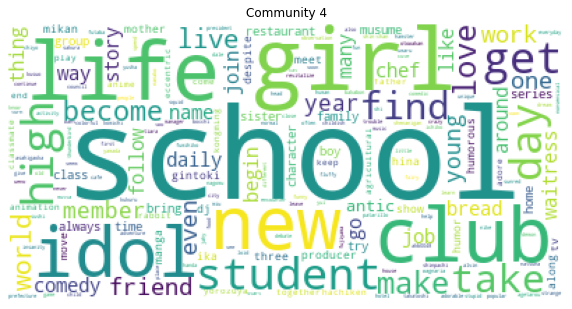

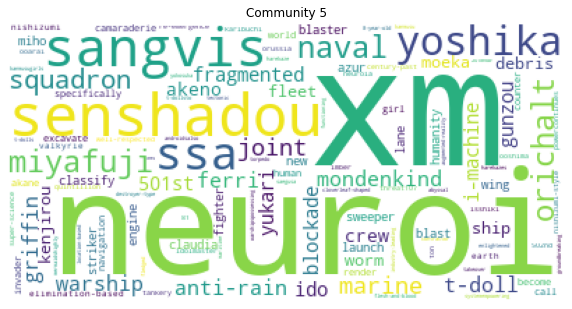

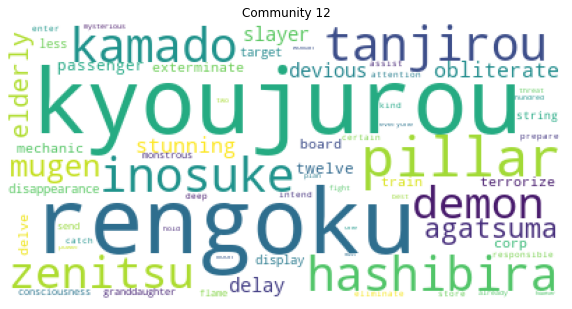

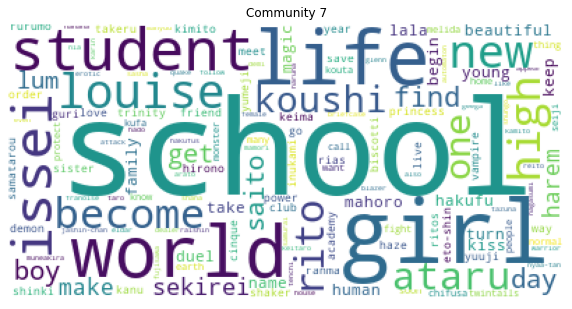

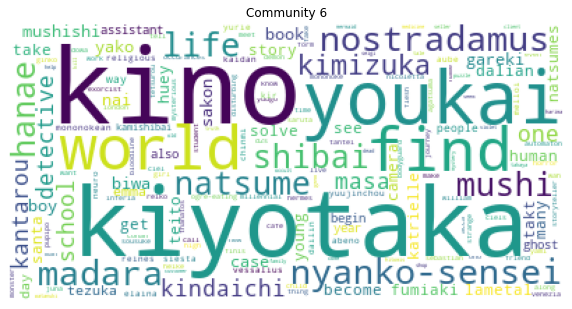

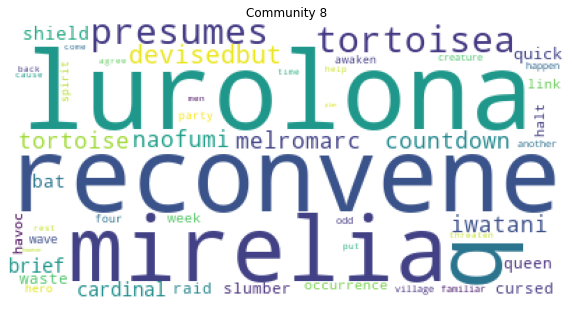

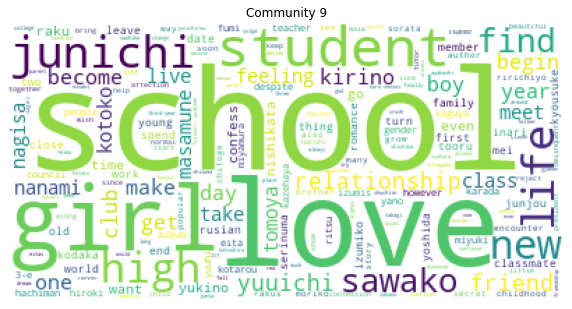

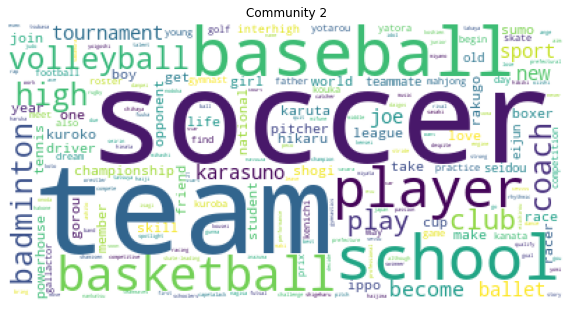

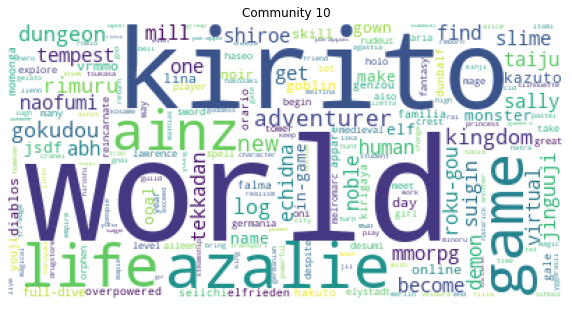

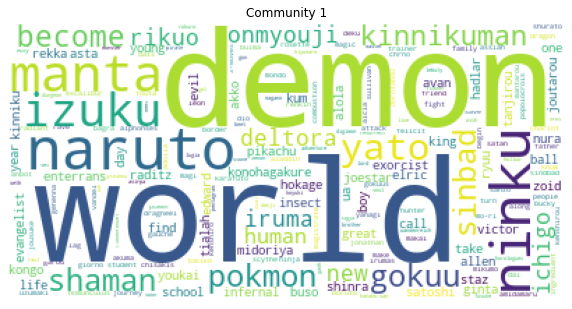

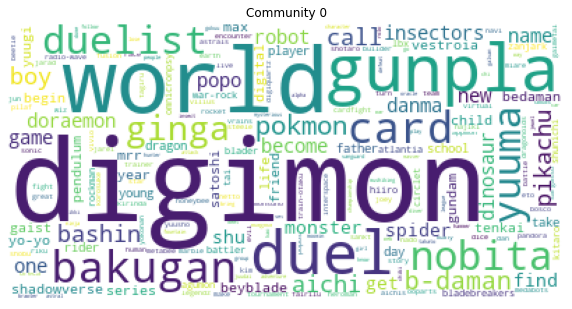

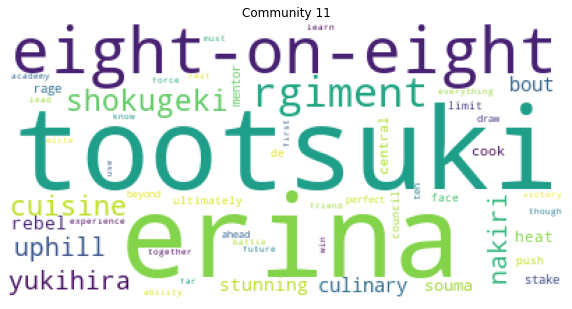

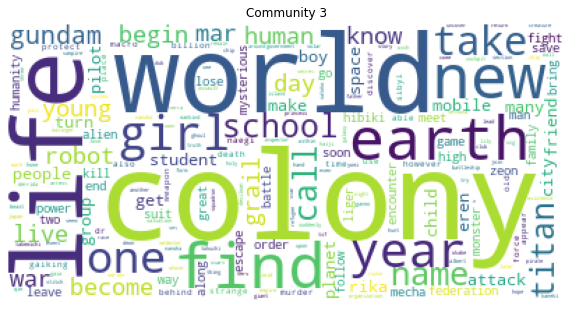

In [ ]:
# Create word clouds for each anime community
for i, tf_idf in zip(list(anime_freq),community_list_tf_idf):
    make_word_cloud(dict(tf_idf),i)

#### Other information from each community of all anime (WIP)

In [ ]:
anime_id_communities = createAnimeCommunities(anime_partition, list(anime_freq))

In [ ]:
community_genres = []
community_scores = []
community_members = []
community_year = []
community_recommendations = []
community_episodes = []
community_themes = []
community_demos = []
community_studios = []
community_anime_count = []
community_sources = []


for i in range(0,len(community_list)):
    anime_list = anime_id_communities[i]
    anime_df = df.loc[anime_list]

    community_anime_count.append(len(anime_df))

    # Mean values
    community_scores.append(anime_df["score"].mean())
    community_members.append(anime_df["members"].mean())
    community_recommendations.append(anime_df["recommendations"].mean())
    community_year.append(anime_df["year"].mean())
    community_episodes.append(anime_df["episodes"].mean())

    # Frequencies
    all_genres = []
    all_themes = []
    all_demos = []
    all_studios = []
    all_sources = []
    for i in anime_list:
        all_genres.append(df.loc[i]["genres"])
        all_themes.append(df.loc[i]["themes"])
        all_demos.append(df.loc[i]["demographics"])
        all_studios.append(df.loc[i]["studios"])
        all_sources.append([df.loc[i]["source"]])

    genre_freq = nltk.FreqDist([genre for genrelist in all_genres for genre in genrelist])
    community_genres.append(dict(genre_freq.most_common()))

    theme_freq = nltk.FreqDist([theme for themelist in all_themes for theme in themelist])
    community_themes.append(dict(theme_freq.most_common()))

    demo_freq = nltk.FreqDist([demo for demolist in all_demos for demo in demolist])
    community_demos.append(dict(demo_freq.most_common()))

    studio_freq = nltk.FreqDist([studio for studiolist in all_studios for studio in studiolist])
    community_studios.append(dict(studio_freq.most_common()))

    source_freq = nltk.FreqDist([source for sourcelist in all_sources for source in sourcelist])
    community_sources.append(dict(source_freq.most_common()))


community_df = pd.DataFrame({"community": community_list,"animeCount": community_anime_count,
                            "score": community_scores, "members": community_members, 
                            "recommendations": community_recommendations, "episodes": community_episodes,
                            "year": community_year, "genres": community_genres,
                            "themes": community_themes, "demographics": community_demos,
                            "studios": community_studios, "sources": community_sources})

community_df = community_df.set_index('community')

In [ ]:
community_df

,animeCount,score,members,recommendations,episodes,year,genres,themes,demographics,studios,sources
community,,,,,,,,,,,
4,633,6.922212,146766.695103,19.677725,18.686804,2012.639241,"{'Comedy': 504, 'Slice of Life': 217, 'Romance...","{'School': 222, 'CGDCT': 83, 'Gag Humor': 67, ...","{'Shounen': 103, 'Seinen': 100, 'Shoujo': 22, ...","{'J.C.Staff': 37, 'Doga Kobo': 26, 'Sunrise': ...","{'Manga': 256, 'Original': 110, '4-koma manga'..."
5,532,6.973421,214282.001880,22.370301,22.231203,2006.257519,"{'Sci-Fi': 311, 'Action': 302, 'Drama': 171, '...","{'Mecha': 186, 'Military': 87, 'Space': 82, 'P...","{'Shounen': 101, 'Seinen': 55, 'Kids': 10, 'Sh...","{'Sunrise': 67, 'Madhouse': 31, 'Toei Animatio...","{'Original': 228, 'Manga': 152, 'Game': 32, 'L..."
12,320,6.890125,51657.309375,15.456250,34.667712,2005.187500,"{'Comedy': 130, 'Fantasy': 117, 'Action': 95, ...","{'Mahou Shoujo': 74, 'School': 54, 'Mecha': 36...","{'Shoujo': 102, 'Shounen': 32, 'Kids': 21, 'Se...","{'Toei Animation': 43, 'Sunrise': 18, 'J.C.Sta...","{'Original': 123, 'Manga': 88, 'Game': 26, 'Un..."
7,276,7.152862,111971.463768,17.750000,25.890511,2006.829710,"{'Fantasy': 120, 'Drama': 104, 'Adventure': 10...","{'Historical': 76, 'Mythology': 27, 'School': ...","{'Shounen': 36, 'Shoujo': 35, 'Seinen': 26, 'K...","{'Nippon Animation': 21, 'Toei Animation': 16,...","{'Manga': 98, 'Light novel': 41, 'Novel': 40, ..."
6,274,7.194818,295248.485401,28.850365,18.697080,2010.357664,"{'Romance': 187, 'Comedy': 141, 'Drama': 132, ...","{'School': 137, 'Harem': 56, 'Love Polygon': 2...","{'Shounen': 42, 'Seinen': 28, 'Josei': 10, 'Sh...","{'J.C.Staff': 19, 'Shaft': 12, 'feel.': 12, 'A...","{'Manga': 109, 'Light novel': 51, 'Visual nove..."
8,260,6.724346,199143.430769,23.107692,18.153846,2008.319231,"{'Comedy': 172, 'Romance': 133, 'Ecchi': 123, ...","{'School': 91, 'Harem': 88, 'Super Power': 24,...","{'Shounen': 57, 'Seinen': 24, 'Shoujo': 5, 'Ki...","{'J.C.Staff': 21, 'Xebec': 15, 'Studio Deen': ...","{'Manga': 106, 'Light novel': 84, 'Original': ..."
9,258,7.128953,121200.042636,13.224806,30.011628,2006.956863,"{'Sports': 148, 'Drama': 78, 'Action': 69, 'Co...","{'School': 82, 'Team Sports': 77, 'Music': 22,...","{'Shounen': 99, 'Seinen': 22, 'Shoujo': 12, 'K...","{'Madhouse': 17, 'TMS Entertainment': 17, 'Pro...","{'Manga': 141, 'Original': 53, 'Game': 17, 'Li..."
2,238,7.036134,164805.453782,21.344538,19.861345,2008.105042,"{'Action': 161, 'Sci-Fi': 82, 'Comedy': 70, 'A...","{'Historical': 42, 'Super Power': 42, 'Adult C...","{'Seinen': 44, 'Shounen': 40, 'Shoujo': 6, 'Ki...","{'Madhouse': 21, 'Bones': 15, 'Gonzo': 14, 'St...","{'Manga': 89, 'Original': 70, 'Game': 19, 'Lig..."
10,211,7.351232,424997.635071,28.028436,44.825243,2007.213270,"{'Action': 139, 'Fantasy': 109, 'Adventure': 1...","{'Mythology': 47, 'School': 32, 'Historical': ...","{'Shounen': 132, 'Shoujo': 13, 'Kids': 12, 'Jo...","{'Toei Animation': 32, 'Pierrot': 17, 'Studio ...","{'Manga': 158, 'Original': 12, 'Game': 9, 'Lig..."


In [ ]:
community_df.loc[10]

animeCount                                                       211
score                                                        7.35123
members                                                       424998
recommendations                                              28.0284
episodes                                                     44.8252
year                                                         2007.21
genres             {'Action': 139, 'Fantasy': 109, 'Adventure': 1...
themes             {'Mythology': 47, 'School': 32, 'Historical': ...
demographics       {'Shounen': 132, 'Shoujo': 13, 'Kids': 12, 'Jo...
studios            {'Toei Animation': 32, 'Pierrot': 17, 'Studio ...
sources            {'Manga': 158, 'Original': 12, 'Game': 9, 'Lig...
Name: 10, dtype: object

In [ ]:
# All anime from community 10, which is the community with most members
print(f"Dataframe from community: {community_list[8]}")
df.loc[anime_id_communities[8]]

Dataframe from community: 10


,title,source,episodes,airing,duration,rating,score,scored_by,rank,popularity,members,favorites,synopsis,season,year,studios,genres,themes,demographics,recommendations
mal_id,,,,,,,,,,,,,,,,,,,,
1735,Naruto: Shippuuden,Manga,500.0,False,23 min per ep,PG-13 - Teens 13 or older,8.25,1487306,283,16,2212915,102011,It has been two and a half years since Naruto ...,winter,2007.0,[Pierrot],"[Action, Adventure, Fantasy]",[Martial Arts],[Shounen],90
1537,Genshi Shounen Ryuu,Manga,22.0,False,25 min per ep,PG-13 - Teens 13 or older,6.27,627,7773,10036,2114,5,When Ryuu is born his tribe tries to sacrifice...,fall,1971.0,[Toei Animation],"[Action, Adventure, Romance, Sci-Fi]",[],[Shounen],3
41911,Hanyou no Yashahime: Sengoku Otogizoushi,Original,24.0,False,24 min per ep,PG-13 - Teens 13 or older,6.71,32098,5331,1680,111660,606,Half-demon twins Towa and Setsuna were always ...,fall,2020.0,[Sunrise],"[Action, Adventure, Comedy, Fantasy, Supernatu...","[Historical, Mythology, Time Travel]",[],3
11061,Hunter x Hunter (2011),Manga,148.0,False,23 min per ep,PG-13 - Teens 13 or older,9.04,1558047,10,10,2494964,190706,Hunters devote themselves to accomplishing haz...,fall,2011.0,[Madhouse],"[Action, Adventure, Fantasy]",[],[Shounen],167
14333,Tanken Driland,Game,37.0,False,20 min per ep,PG - Children,6.55,1631,6192,7014,6144,15,Due to the influence of someone who visited he...,summer,2012.0,[Toei Animation],"[Adventure, Fantasy]",[],[],7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39534,Jibaku Shounen Hanako-kun,Manga,12.0,False,24 min per ep,PG-13 - Teens 13 or older,7.85,252478,816,364,515022,10766,"The famous ""Seven Wonders"" that every school s...",winter,2020.0,[Lerche],"[Comedy, Supernatural]",[School],[Shounen],45
131,Saiyuuki Reload Gunlock,Manga,26.0,False,24 min per ep,PG-13 - Teens 13 or older,7.39,8287,2108,4150,22330,44,The Sanzo Ikkou continues its westward journey...,spring,2004.0,[Pierrot],"[Action, Adventure, Comedy, Drama, Supernatural]",[Mythology],[Josei],1
14921,RDG: Red Data Girl,Novel,12.0,False,24 min per ep,PG-13 - Teens 13 or older,6.56,47259,6097,1746,106644,221,Fifteen-year-old Izumiko Suzuhara just wants t...,spring,2013.0,[P.A. Works],"[Drama, Fantasy, Romance]","[Mythology, School]",[],35


In [ ]:
common_succesful_anime = (set(df.loc[anime_id_communities[8]]["title"]) & set(succes_anime["title"]))
len(common_succesful_anime)

63

In [ ]:
len(common_succesful_anime)/len(df.loc[anime_id_communities[8]]["title"])*100

29.85781990521327

In [ ]:
common_succesful_anime

{'Akame ga Kill!',
 'Ao no Exorcist',
 'Ao no Exorcist: Kyoto Fujouou-hen',
 'Beelzebub',
 'Black Clover',
 'Bleach',
 'Blood Lad',
 'Boku no Hero Academia',
 'Boku no Hero Academia 2nd Season',
 'Boku no Hero Academia 3rd Season',
 'Boku no Hero Academia 4th Season',
 'Boku no Hero Academia 5th Season',
 'Boruto: Naruto Next Generations',
 'Chainsaw Man',
 'D.Gray-man',
 'Dragon Ball',
 'Dragon Ball Super',
 'Dragon Ball Z',
 'Enen no Shouboutai',
 'Enen no Shouboutai: Ni no Shou',
 'Fairy Tail',
 'Fairy Tail (2014)',
 'Fairy Tail: Final Series',
 'Fruits Basket 1st Season',
 'Fullmetal Alchemist',
 'Fullmetal Alchemist: Brotherhood',
 'Hataraku Maou-sama!',
 'Hunter x Hunter',
 'Hunter x Hunter (2011)',
 'Inu x Boku SS',
 'InuYasha',
 'Jibaku Shounen Hanako-kun',
 'JoJo no Kimyou na Bouken (TV)',
 'JoJo no Kimyou na Bouken Part 3: Stardust Crusaders',
 'JoJo no Kimyou na Bouken Part 4: Diamond wa Kudakenai',
 'JoJo no Kimyou na Bouken Part 5: Ougon no Kaze',
 'Jujutsu Kaisen',
 'Kami

**** 

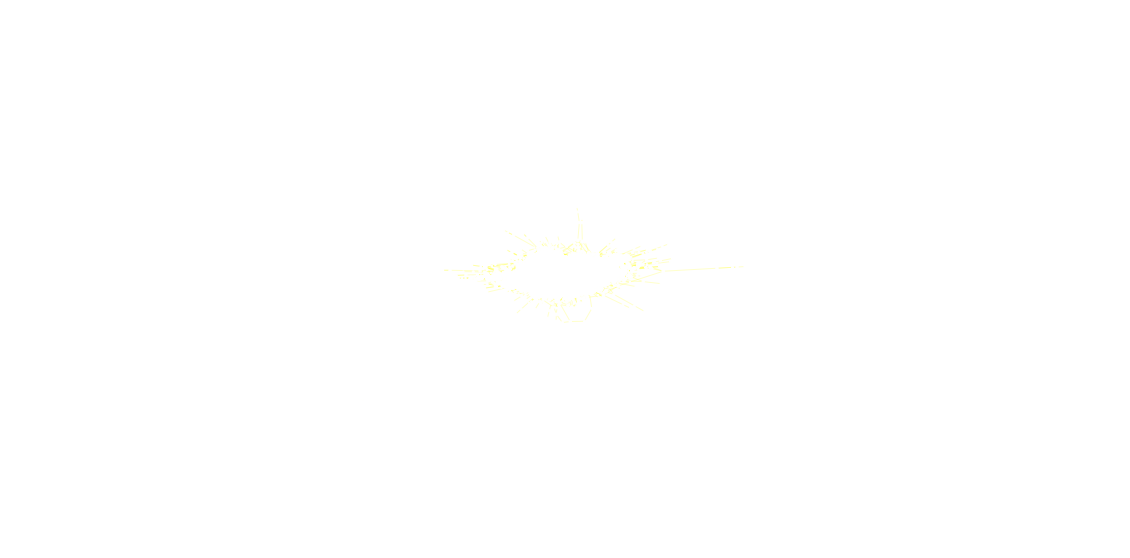

In [ ]:
import fa2
d = dict(anime_graph.degree)
def fa_plot(graph,d,node_scale):
    color_map = []

    # for n in graph.nodes:
    #     if 'attr' in graph.nodes[n]:
    #         t = graph.nodes[n]['attr']['team']
    #         if t == 'dc':
    #             color_map.append("#ff0000")
    #         elif t =='marvel':
    #             color_map.append("#A0CBE2")
    #     else:
    #         color_map.append("#000000")
            
    forceatlas2 = fa2.ForceAtlas2(
                            # Behavior alternatives
                            outboundAttractionDistribution=False,
                            linLogMode=False,
                            adjustSizes=False,
                            edgeWeightInfluence=0.5,

                            # Performance
                            jitterTolerance=1.0,  # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=1.2,
                            multiThreaded=False,  # NOT IMPLEMENTED

                            # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,

                            # Log
                            verbose=False)

    positions = forceatlas2.forceatlas2_networkx_layout(graph, pos=None, iterations=500)
    nx.draw_networkx_edges(graph, positions, edge_color="yellow", alpha=0.2)
    nx.draw_networkx_nodes(graph, positions, node_size=[v * node_scale for v in d.values()], alpha=1, node_color='w')
    #Give the nodes their correct color
    nx.draw_networkx_nodes(graph, positions, node_color=color_map, node_size=[v * node_scale for v in d.values()], alpha=0.7)
    plt.axis('off')
    plt.show()
    
fa_plot(anime_graph,d,2)

# Sentiment

First we get the synopsis of each anime tv show, and store it in a seperate text file.

In [ ]:
import os
path = os.path.join("data","synopsis")
os.makedirs(path)

FileExistsError: [Errno 17] File exists: 'data/synopsis'

In [ ]:
for anime in all_anime_tv:
    file_name = "{}.txt".format(anime['mal_id'])
    write_file = open("data/synopsis/"+file_name, "w")
    write_file.write(json.dumps(anime['synopsis']))
    write_file.close()

Tokenize the synopsis, and remove stop words.

In [ ]:
from bs4 import BeautifulSoup
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.corpus import PlaintextCorpusReader
#The root is the directory
corpus_root_dc = r"data/synopsis" 
file_pattern = r".*\.txt"
ptb_dc = PlaintextCorpusReader(corpus_root_dc, file_pattern)
xx = 0
token_dict = {}
for fileid in ptb_dc.fileids():
    raw = ptb_dc.raw(fileids=fileid)
    #raw = BeautifulSoup(html, 'html.parser').get_text()
    try: 
        start = re.search('\"',raw).span()[1]
    except AttributeError:
        print("error")
    tokens = word_tokenize(raw[start:])
    token_dict[fileid.split('.txt')[0]] = [w.lower() for w in tokens if w.isalpha()]

stop_words = stopwords.words('english')

for k,v in token_dict.items(): #remove stop words from token_dict for later sentiment use
    token_dict[k] = [w for w in v if w not in stop_words]

Store the average happiness score of words:

In [ ]:
class Word:
    def __init__(self,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank):
        self.word = word
        self.happiness_average = float(happiness_average)

labMIT = {}
with open("labMIT.txt") as f:
    for line in f:
       (word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank) = line.split()
       labMIT[word] = Word(word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank)


We create a function that can calculate the sentiment of a given tokenlist

In [ ]:
def get_sentiment(tokenlist):
    sentiment = 0
    num_of_tokens = len(tokenlist)
    if num_of_tokens == 0:
        print('input tokenlist was empty')
        num_of_tokens = 1
    
    for w in tokenlist:
        try: 
            sentiment = sentiment + (labMIT[str(w)].happiness_average)
        except KeyError:
            if num_of_tokens > 1:
                num_of_tokens = num_of_tokens-1
                
    sentiment = sentiment/num_of_tokens
    return sentiment

We can now calculate the sentiment of all the synopsis

In [ ]:
fails = 0
sentiments = []
for mal_id in anime_graph.nodes:
    try:
        s = get_sentiment(token_dict[str(mal_id)])
        anime_graph.nodes[mal_id]['Sentiment'] = s
        if s != 0: #We dont consider pages with sentiment 0, as these contain no words in our sentiment library.
            sentiments.append(s)
    except KeyError:
        fails = fails + 1

#print(fails,"nodes could not have their sentiment calculated")

We define a couple of functions for plotting pretty histograms along with their mean, as well as 10th and 90th percentile.

The functions: outlier_aware_sentiment_hist, mad, calculate_bounds is a modified version of the code posted by user Benjamin Doughty in the stackoverflow thread [Making pyplot.hist() first and last bins include outliers](https://stackoverflow.com/questions/15837810/making-pyplot-hist-first-and-last-bins-include-outliers)

In [ ]:
def outlier_aware_sentiment_hist(data,mean,tenth,ninetieth,t,sent=False,lower=None, upper=None):
    if not lower or lower < min(data):
        lower = min(data)
        lower_outliers = False
    else:
        lower_outliers = True

    if not upper or upper > max(data):
        upper = max(data)
        upper_outliers = False
    else:
        upper_outliers = True

    n, bins, patches = plt.hist(data, range=(lower, upper), bins='auto',edgecolor='black')

    if lower_outliers:
        n_lower_outliers = sum(data < lower)
        patches[0].set_height(patches[0].get_height() + n_lower_outliers)
        patches[0].set_facecolor('c')
        patches[0].set_label('Lower outliers: ({:.2f}, {:.2f})'.format(min(data), lower))

    if upper_outliers:
        n_upper_outliers = sum(data > upper)
        patches[-1].set_height(patches[-1].get_height() + n_upper_outliers)
        patches[-1].set_facecolor('m')
        patches[-1].set_label('Upper outliers: ({:.2f}, {:.2f})'.format(upper, max(data)))
    if sent:
        plt.plot([mean,mean],[0,max(n)*1.02],linewidth=5)
        plt.plot([tenth,tenth],[0,max(n)*1.02],linewidth=5)
        plt.plot([ninetieth,ninetieth],[0,max(n)*1.02],linewidth=5)
        plt.legend(['Lower outliers: ({:.2f}, {:.2f})'.format(min(data), lower),('Upper outliers: ({:.2f}, {:.2f})'.format(upper, max(data))),('Distribution Mean: {:.2f}'.format(mean)),('10th percentile: {:.2f}'.format(tenth)),'90th percentile: {:.2f}'.format(ninetieth)])
        plt.xlabel('Sentiment value')
        plt.ylabel('Count')
    else:
        plt.legend()
    plt.title(t)
        
def mad(data):
    median = np.median(data)
    diff = np.abs(data - median)
    mad = np.median(diff)
    return mad

def calculate_bounds(data, z_thresh=3.5):
    MAD = mad(data)
    median = np.median(data)
    const = z_thresh * MAD / 0.6745
    return (median - const, median + const)

def sentiment_stats_and_hist(sents,t):
    sent_mean = mean(sents)
    tenth = np.percentile(sents,10)
    ninetieth = np.percentile(sents,90)
    print("Sentiment mean:",sent_mean)
    print("tenth percentile:",tenth)
    print("ninetieth percentile:",ninetieth)
    outlier_aware_sentiment_hist(sents,sent_mean,tenth,ninetieth,t,True,*calculate_bounds(sents))


Sentiment mean: 5.716140110765166
tenth percentile: 5.354153846153846
ninetieth percentile: 6.068976623376623


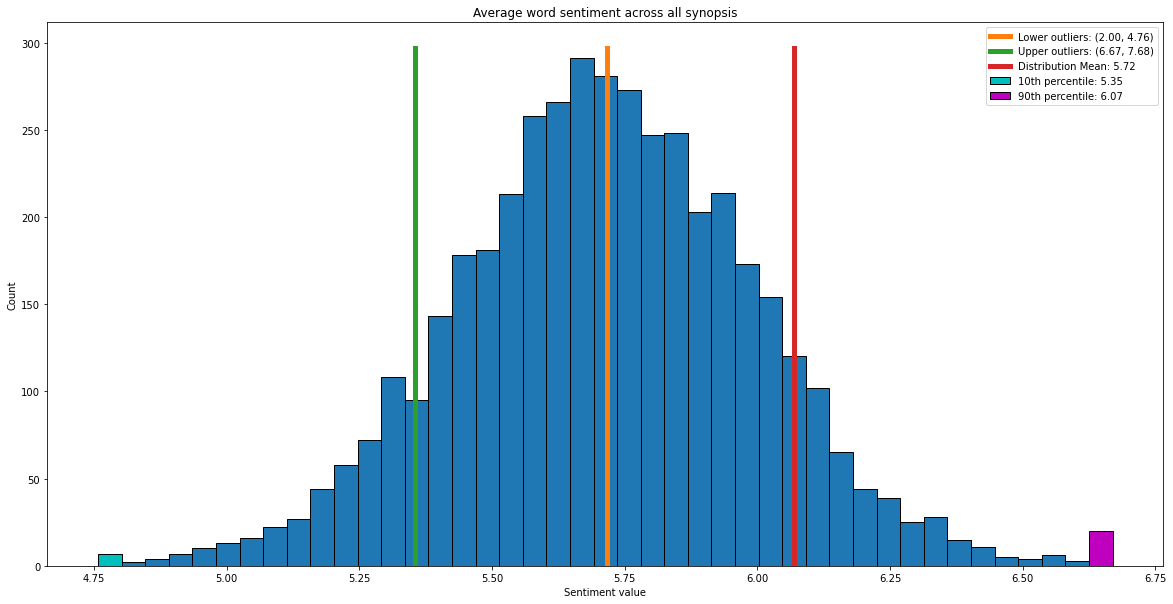

In [ ]:
sentiment_stats_and_hist(sentiments,'Average word sentiment across all synopsis')

# Next steps

Split datasettet op i nogle kategorier og sammenlign?<br>F.eks. høj rating vs lav rating? men hvor er cut offet?<br>
Evt. gradierer farven på noderne i plottet alt efter rating? hvis det er muligt, kunne være blæret.<br>
Evt. et møde med sune for at høre hvad der giver mening.